In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models

import cv2
from matplotlib import pyplot as plt

import utils

%matplotlib inline

<B> Load the image, then convert and normalize to torch tensor of appropriate dimensions </B>

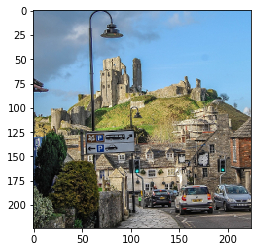

In [2]:
img = np.array(cv2.imread('image/castle.jpg'))[..., ::-1] / 255.0
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
X = (torch.FloatTensor(img[np.newaxis].transpose([0, 3, 1, 2])*1) - mean) / std

plt.imshow(img)

<B> Load pretrained ResNet34 network, check its prediction wrt the image (we will convert the model's dense layers to convolutional layers later on) </B>

In [3]:
model = models.resnet34(pretrained=True)
model.eval()

scores = model(X).detach().numpy().reshape(-1)
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 12.551
church, church build (497):  9.393
thatch, thatched roo (853):  9.121
streetcar, tram, tra (829):  8.851
           monastery (663):  8.523
 bell cote, bell cot (442):  8.346
dock, dockage, docki (536):  8.284
                pole (733):  8.085
         street sign (919):  7.923
cinema, movie theate (498):  7.771


<B> Convert ResNet network to simplify LRP process </B>

In [4]:
convs = utils.dense2conv([model._modules['fc']], is_vgg=False)
convs = nn.Sequential(utils.UnFlatten(1, 1), *convs)
model.fc = convs
model.avgpool= torch.nn.AvgPool2d((7, 7))

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<B> Assure the result of the modified model is the same as original one </B>

In [5]:
scores = model(X).detach().numpy().reshape(-1)
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 12.551
church, church build (497):  9.393
thatch, thatched roo (853):  9.121
streetcar, tram, tra (829):  8.851
           monastery (663):  8.523
 bell cote, bell cot (442):  8.346
dock, dockage, docki (536):  8.284
                pole (733):  8.085
         street sign (919):  7.923
cinema, movie theate (498):  7.771


<B> ResNet is not simple flat-structured layers, we'll parse its module hierarchy to extract the top-level blocks and layers within each top-level block. <br/>
It's also needed to handle skip connections accordingly </B>

In [6]:
class Add(nn.Module):
    def __init__(self, in_channels=2):
        super(Add, self).__init__()
        
    def forward(self, master, side):
        return torch.add(master, side)

class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Identity, self).__init__() 
    def forward(self, x):
        return x      

# originally, I plan to write general rule for resnet's BasicBlock and Bottleneck. 
# I then realized to use specific logic for their composition is way simpler.
# Here keep the code for my original intention...
def retrieve_blocks(model):
    blks = []
    blk_layers = []
    for i, (mod_name, mod) in enumerate(model.named_children()):
        if isinstance(mod, nn.Sequential):
            for j, (blk_name, blk) in enumerate(mod.named_children()):
                layers = [ layer for layer_name, layer in blk.named_children() 
                            if layer_name != 'downsample' ]
                layers = [ *layers, Add(), nn.ReLU() ]
                sidelayers = [ sidelayer for layer_name, layer in blk.named_children()
                                           for sidelayer in layer.children() 
                                               if layer_name == 'downsample' ]
                sidelayers = [ *sidelayers, Identity() ]
                
                blks.append(blk)
                blk_layers.append({'master': layers, 'side': sidelayers})
                if mod_name != 'fc':
                    setattr(blk, 'BasicBlock', True)    
        if not list(mod.children()): # leaf
            blks.append(mod)
            blk_layers.append([])
    return blks, blk_layers


blks, blk_layers = retrieve_blocks(model)

print('Top-level Blocks')
for i, blk in enumerate(blks):
    print(f'{i}: {blk}')
print('---------------------------------')
print('Skip Connection within BasicBlock')
for i, layer in enumerate(blk_layers):
    if layer:
        print(f'{i}: master: {layer["master"]}')
        print(f'{i}: side: {layer["side"]}')

Top-level Blocks
0: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU(inplace=True)
3: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
5: BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2)

<B> Iterate top-level blocks to get Activations of each block, check the final prediction is correct again! </B>

In [7]:
L = len(blks)
A = [X]+[None]*L
for l in range(L): 
    A[l+1] = blks[l].forward(A[l]).detach() # A[0..L] is a list of tensors (for Activations)
    
scores = A[-1].numpy().reshape(-1) 
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 12.551
church, church build (497):  9.393
thatch, thatched roo (853):  9.121
streetcar, tram, tra (829):  8.851
           monastery (663):  8.523
 bell cote, bell cot (442):  8.346
dock, dockage, docki (536):  8.284
                pole (733):  8.085
         street sign (919):  7.923
cinema, movie theate (498):  7.771


In [8]:
target_index = 483 # castle

# top blk level
T = torch.FloatTensor((1.0*(np.arange(1000)==target_index).reshape([1,1000,1,1])))
R = [None]*L + [A[-1]*T]  # R[0..L] is a list of tensors (for Relevance) 

In [9]:
def get_txf_funcs(num_layer):
    if num_layer <= 6:
        rho = lambda p: p + 0.25*p.clamp(min=0)
        incr = lambda z: z+1e-9
    elif num_layer <= 16: 
        rho = lambda p: p
        incr = lambda z: z+1e-9 + 0.25*((z**2).mean()**.5).data
    else:       
        rho = lambda p: p
        incr = lambda z: z+1e-9    
    return rho, incr


# layers within top-blocks
def blk_layers_rprop(a, blk_layer, num_layer, R):
    master_layers = blk_layer['master']
    side_layers = blk_layer['side']
    
    ## BasicBlock forward (side first, master second)
        # Am[Lm+1] for activation of master
        # As[Ls+1] for activation of side
        # Id for Identity value
    Lm = len(master_layers)
    Am = [a]+[None]*Lm
    Ls = len(side_layers)
    As = [a]+[None]*Ls
    Id = None
    # As[...] is a list of tensors (Activations of side path)
    for l in range(Ls):
        As[l+1] = side_layers[l].forward(As[l]).detach()
        if isinstance(side_layers[l], Identity):
            Id = As[l+1]
            
    # Am[...] is a list of tensors (Activations of master path)            
    for l in range(Lm):
        if isinstance(master_layers[l], Add):
            Am[l+1] = master_layers[l].forward(Am[l], Id).detach()
        else:
            Am[l+1] = master_layers[l].forward(Am[l]).detach()

    print(f'\tSanity Check: top-level A[{num_layer}].sum = {A[num_layer].sum()} == Am[0].sum = {Am[0].sum()}')            
    print(f'\tSanity Check: top-level A[{num_layer+1}].sum = {A[num_layer+1].sum()} == Am[-1].sum = {Am[-1].sum()}')
     
    ## BasicBlock backward (master first, side second)
    Rm = [None]*Lm + [R]
    RId = None
    for l in range(Lm)[::-1]:
        if isinstance(master_layers[l], Add):
            # Ever Tried: (1) LRP-Prop: aR/(a+b) and bR/(a+b) [Here we use, should handle divided by zero case, e.g. a+b=0]
            #             (2) LRP-abs: |a|R/(|a|+|b|) and |b|R/(|a|+|b|) 
            #             (3) LRP-half: 0.5R and 0.5R 
            #             (4) LRP-all: R for master, 0 for side
            Rm[l] = Rm[l+1] * ((Am[l] / (Am[l] + Id)).detach())
            RId = Rm[l+1] * ((Id / (Am[l] + Id)).detach())
        elif isinstance(master_layers[l], torch.nn.Conv2d):
            Am[l].requires_grad_()
            if Am[l].grad is not None:
                Am[l].grad.zero_()
            rho, incr = get_txf_funcs(num_layer)
            z = incr(utils.newlayer(master_layers[l], rho).forward(Am[l]))    # step 1
            s = (Rm[l+1]/z).detach()                                          # step 2
            (z*s).sum().backward(); c = Am[l].grad                            # step 3
            Rm[l] = (Am[l]*c).detach()                                        # step 4
        else:
            Rm[l] = Rm[l+1]
            
    Rs = [None]*Ls + [RId]           
    for l in range(Ls)[::-1]:
        if isinstance(side_layers[l], torch.nn.Conv2d):
            As[l].requires_grad_()
            if As[l].grad is not None:
                As[l].grad.zero_()
            rho, incr = get_txf_funcs(num_layer)
            z = incr(utils.newlayer(side_layers[l], rho).forward(As[l]))     # step 1
            s = (Rs[l+1]/z).detach()                                         # step 2
            (z*s).sum().backward(); c = As[l].grad                           # step 3
            Rs[l] = (As[l]*c).detach()                                       # step 4
        else:
            Rs[l] = Rs[l+1]
    
    print(f"\tRelevance BackProp within BasicBlock{num_layer} sum={(Rm[0] + Rs[0]).sum()}, master's sum={Rm[0].sum()}, side's sum={Rs[0].sum()}")
    return Rm[0] + Rs[0]   
    

# top-level block
def blk_rprop(a, blk, num_layer, R):
    if hasattr(blk, 'BasicBlock'): # BasicBlock or Bottleneck Block
        return blk_layers_rprop(a, blk_layers[num_layer], num_layer, R)
    
    if isinstance(blk, torch.nn.Conv2d) or isinstance(blk, torch.nn.AvgPool2d):
        a.requires_grad_() 
        if a.grad is not None:
            a.grad.zero_()
        rho, incr = get_txf_funcs(num_layer)
        z = incr(utils.newlayer(blk, rho).forward(a))   # step 1
        s = (R/z).detach()                              # step 2
        (z*s).sum().backward(); c = a.grad              # step 3
        R = (a*c).detach()                              # step 4
    else:
        R = R
    return R


# top blk level
for l in range(1, L)[::-1]:
    if isinstance(blks[l], torch.nn.MaxPool2d): # replace maxpool as avgpool for LRP
        blks[l] = torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
    R[l] = blk_rprop(A[l], blks[l], l, R[l+1])
    print(f'Top-level R[{l}] sum = {R[l].sum()}')

Top-level R[22] sum = 12.554961204528809
Top-level R[21] sum = 12.554961204528809
Top-level R[20] sum = 12.554962158203125
	Sanity Check: top-level A[19].sum = 10995.04296875 == Am[0].sum = 10995.04296875
	Sanity Check: top-level A[20].sum = 26493.216796875 == Am[-1].sum = 26493.216796875
	Relevance BackProp within BasicBlock19 sum=12.554718017578125, master's sum=8.12933349609375, side's sum=4.425314903259277
Top-level R[19] sum = 12.554718017578125
	Sanity Check: top-level A[18].sum = 8159.638671875 == Am[0].sum = 8159.638671875
	Sanity Check: top-level A[19].sum = 10995.04296875 == Am[-1].sum = 10995.04296875
	Relevance BackProp within BasicBlock18 sum=12.5634765625, master's sum=426.0068359375, side's sum=-413.4477233886719
Top-level R[18] sum = 12.5634765625
	Sanity Check: top-level A[17].sum = 6431.14404296875 == Am[0].sum = 6431.14404296875
	Sanity Check: top-level A[18].sum = 8159.638671875 == Am[-1].sum = 8159.638671875
	Relevance BackProp within BasicBlock17 sum=12.7421875, m

### Unfortunately, the relevance scores exploded in backpropagation... 
### The sanity check shows the activation values are actually correct while forward passing layers within top-level blocks. 
### However, the relevance backprop w.r.t skip connections within BasicBlock seem not worked as expected. Four different rules were experimented with no good luck... 

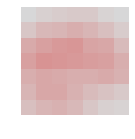

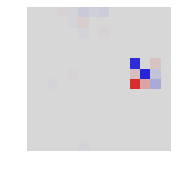

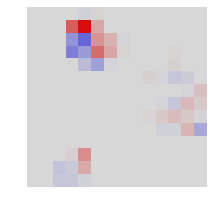

/Users/winston/GitHub/Winston/pytorch_playground/notebook/utils.py:16: RuntimeWarning: overflow encountered in power
  b = 10*((numpy.abs(R)**3.0).mean()**(1.0/3))
/Users/winston/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:397: RuntimeWarning: invalid value encountered in double_scalars
  vmid = self.norm.vmin + dv / 2
/Users/winston/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


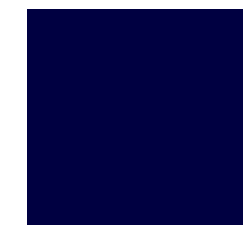

In [10]:
for i,l in enumerate([20, 16, 15, 6]):
    utils.heatmap(np.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

## References:
1. Tutorial on Implementing LRP: http://heatmapping.org/tutorial/
2. LRP Rules & Implementation: http://heatmapping.org/slides/2019_EMBC_2.pdf
3. Interpretability Metrics: http://heatmapping.org/slides/2019_EMBC_3.pdf
4. LRP via PyTorch hook: https://github.com/moboehle/Pytorch-LRP
5. LRP via Python: https://github.com/sebastian-lapuschkin/lrp_toolbox
6. LRP via PyTorch autograd: https://github.com/liamhiley/torchexplain

## Notes:
(1) There is another value-based backpropagation approach 'VisualBackprop' proposed by Nividia+Google Brain+NYC (https://arxiv.org/pdf/1611.05418.pdf). 

    However, the authors didn't open source their code. Followings are two GitHub repositories containing PyTorch implementation. 
    - VGG16: https://github.com/devansh20la/VisualBackprop
    - ResNet50: https://github.com/jenkspt/nvidia-visual-back-propagation

    I didn't get satisfied result when compared with LRP's (using same images)...

(2) Keep watching the avalability of LRP paper author's innvestigate PyTorch support. (https://github.com/albermax/innvestigate/issues/145)